In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import array_to_img

import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/255.0
    input_mask -= 1
    return input_image, input_mask

In [3]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = tf.keras.layers.RandomFlip(mode = "horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode = "horizontal", seed = seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [5]:
# VISUALIZATION 
def display(display_list):
    plt.figure(figsize = (15,15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")

    plt.show()

In [6]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape = [128, 128, 3])

    # downsampling
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # upsampling & skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # last layer
    last = tf.keras.layers.Conv2DTranspose(
        filters = output_channels, kernel_size = 3,
        strides = 2, padding = 'same' ) # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs = inputs, outputs = x)


In [7]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis = -1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


In [8]:
def show_predictions(dataset = None, num = 1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])

    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [9]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        clear_output(wait = True)
        show_predictions()
        print("\nSample Prediction after epoch {}\n".format(epoch+1))


In [10]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info = True)

2022-01-03 20:22:49.028188: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

In [12]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [13]:
# BUILD INPUT PIPELINE
train_batches = (train_images.cache().shuffle(BUFFER_SIZE)
                .batch(BATCH_SIZE).repeat().map(Augment())
                .prefetch(buffer_size = tf.data.experimental.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


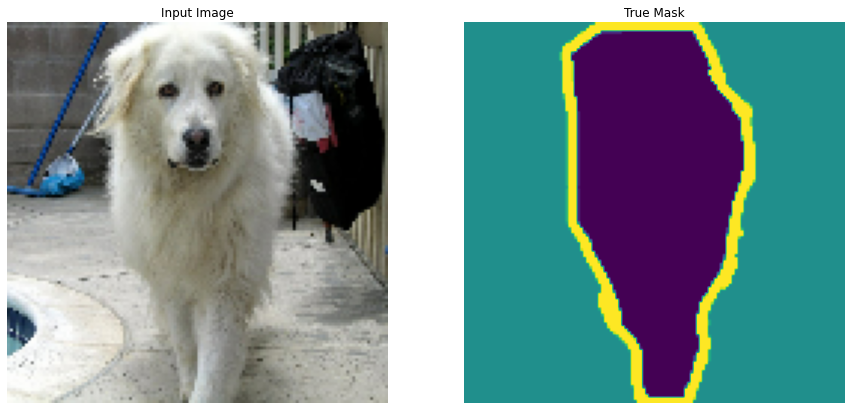

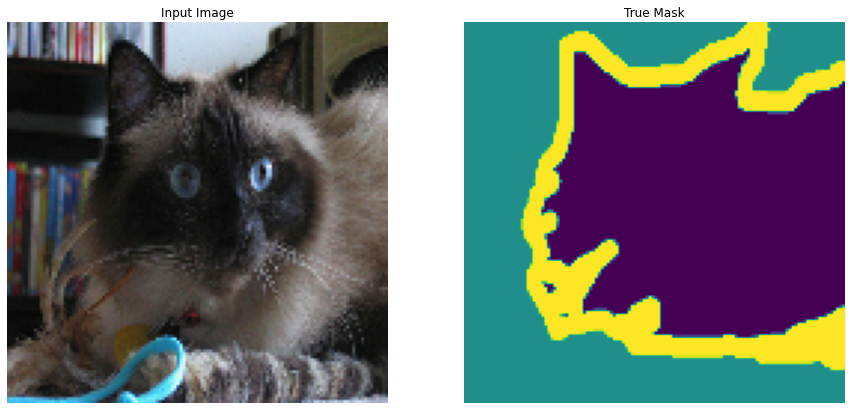

2022-01-03 20:22:52.990095: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
# show sample input // true mask
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])


In [15]:
# BUILDING UNET MODEL
base_model = tf.keras.applications.MobileNetV2(input_shape = [128, 128, 3], include_top = False)

In [16]:
# use activations of:
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# feature extraction
down_stack = tf.keras.Model(inputs = base_model.input, outputs = base_model_outputs)
down_stack.trainable = False

In [17]:
# decoder / upsampler
up_stack = [
    pix2pix.upsample(512, 3),   # 4x4 -> 8x8
    pix2pix.upsample(256, 3),   # 8x8 -> 16x16
    pix2pix.upsample(128, 3),   # 16x16 -> 32x32
    pix2pix.upsample(64, 3),    # 32x32 -> 64x64
]


In [18]:
# Training!
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(
    optimizer = "adam", 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ["accuracy"])


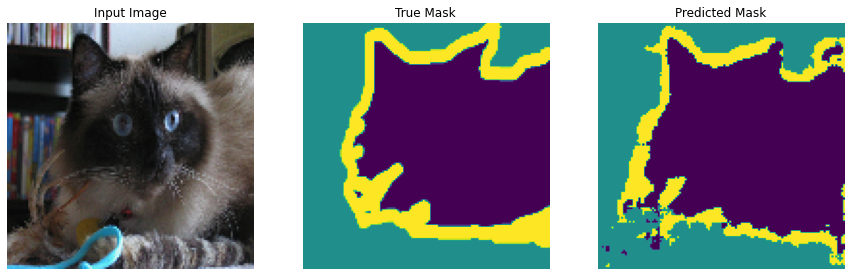


Sample Prediction after epoch 20

57/57 [==============================] - 145s 3s/step - loss: 0.1840 - accuracy: 0.9185 - val_loss: 0.2652 - val_accuracy: 0.8970


In [19]:
model_history = model.fit(
    train_batches, epochs = EPOCHS,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_steps = VALIDATION_STEPS,
    validation_data = test_batches,
    callbacks = [DisplayCallback()]
)

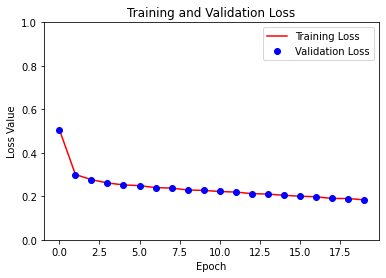

In [20]:
# Loss Curve:
loss = model_history.history['loss']
val_loss = model_history.history['loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label = "Training Loss")
plt.plot(model_history.epoch, val_loss, 'bo', label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.ylim([0,1])
plt.legend()
plt.show()

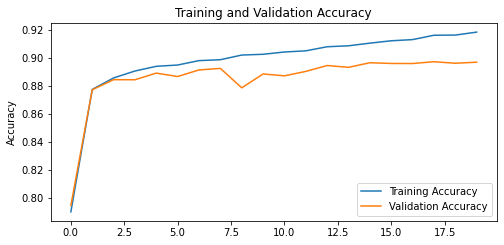

In [24]:
# Accuracy Curve:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize = (8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.ylabel("Accuracy")
plt.ylim([min( plt.ylim() ), max(plt.ylim())])
plt.title("Training and Validation Accuracy")

plt.show()

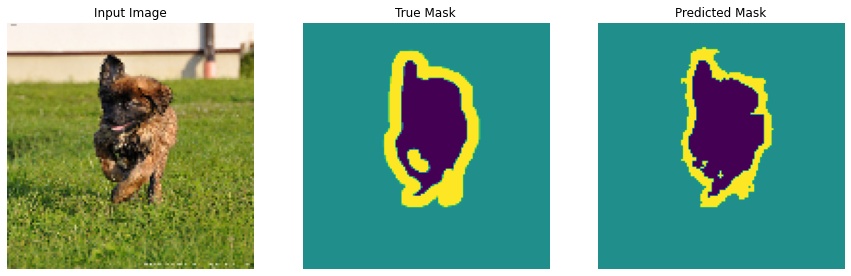

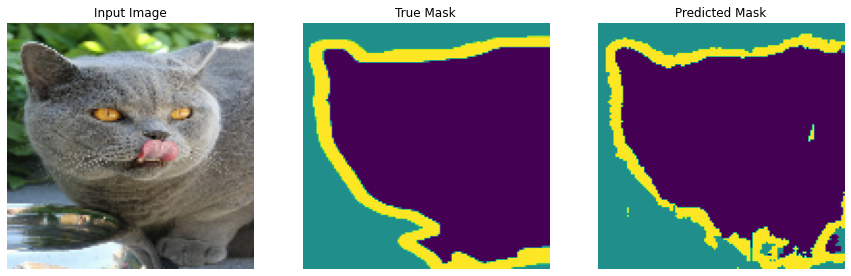

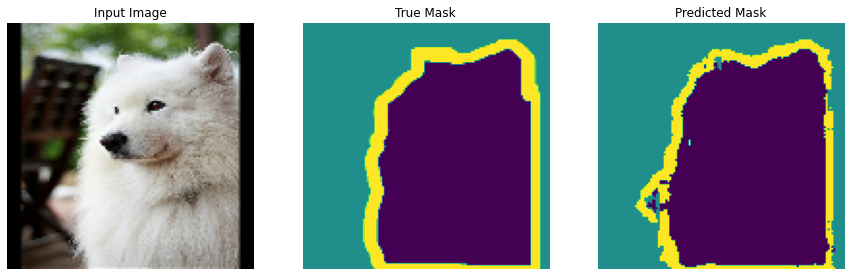

In [21]:
# PREDICTIONS
show_predictions(test_batches, 3)